<a href="https://colab.research.google.com/github/nyjinnn/images/blob/main/220804_%EB%A7%88%EC%A7%80%EB%A7%89!!%20%ED%95%9C%EB%B2%88%20%EB%8D%94%20%EB%8F%8C%EB%A0%A4%EB%B3%B4%EA%B8%B0%20!!!_Final_quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. cifar10 
1. 기간 : 8월 6일까지 제출 (~ 23:59) 
  - 결과 공개는 8월 8일
2. 허용 범위
  - convolution
  - dropout 
  - 모든 전처리 방법 ok 
  - 모든 규제 방법 (L1, L2 등) 허용 
  - 모든 activation 허용
  - 모든 normalization 방법 금지 (batch, layer, weight 등등)
  - 재학습했을 때 결과가 동일해야 함
  - 미니 배치 사용 (배치 사이즈 상관없음) 
  - 파이토치만 쓸 것 
  - 앙상블 허용 
3. 기준 
  - 정확도
  - 모델 파라미터 수  
  - 학습 횟수 (배치 사이즈 x 스텝 x 주기) 
4. 포상 
  - 개인 : 2만원 상당의 무언가
  - 팀 : 간식 (3만원?)



In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

In [9]:
torch.cuda.is_available()

False

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


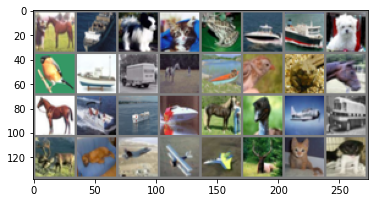

horse  ship   dog   cat


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
from tqdm import tqdm 
import random 

random_seed = 220804
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)


In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 5, padding=5//2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(256, 256, 5, padding=5//2)
        self.conv3 = nn.Conv2d(256, 256, 5, padding=5//2)
        self.conv4 = nn.Conv2d(256, 256, 5, padding=5//2)
        self.fc1 = nn.Linear(256 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        print(x.shape)
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

DEVICE = 'cpu'

net = Net().to(DEVICE)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

for epoch in range(30):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print('Finished Training')

In [ ]:

dataiter = iter(testloader)
images, labels = dataiter.next()

images = images.to('cuda')

imshow(torchvision.utils.make_grid(images.to('cpu')))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))